# Coefficient field inversion in an elliptic partial differential equation

We consider the estimation of a coefficient in an elliptic partial differential equation as a first model problem.
Depending on the interpretation of the unknowns and the type of measurements, this model problem arises, for instance, in electrical impedence tomography.

Let $\Omega\subset\mathbb{R}^n$, $n\in\{1,2,3\}$ be an open, bounded
domain and consider the following problem:

$$
\min_{m} J(m):=\frac{1}{2}\int_{\Omega} (u-d)^2\, dx + \frac{\gamma}{2}\int_\Omega|\nabla m|^2\,dx,
$$

where $u$ is the solution of

$$
\begin{split}
\quad -\nabla\cdot(e^m \nabla u) &= 0 \text{ in }\Omega,\\
e^m \nabla u &= j \text{ on }\partial\Omega.
\end{split}
$$

Here $m \in \mathcal{M}:=\{m\in L^{\infty}(\Omega) \bigcap H^1(\Omega)\}$ denotes the unknown parameter field, 
$u \in \mathcal{V}:= \left\{v \in H^1(\Omega) | v(\boldsymbol{x}_c) = 0 \text{ for a given point } \boldsymbol{x}_c\in \Omega \right\}$ the state variable, $d$ the (possibly noisy) data, $j\in H^{-1/2}(\partial\Omega)$ a given boundary force, and $\gamma\ge 0$ the regularization parameter.

### The variational (or weak) form of the forward problem:

Find $u\in \mathcal{V}$ such that 

$$ \int_{\Omega}e^m \nabla u \cdot \nabla \tilde{p} \, dx - \int_{\partial \Omega} j \tilde{p} \,dx = 0, \text{ for all } \tilde{p}\in \mathcal{V}.$$


### Gradient evaluation:

The Lagrangian functional $\mathscr{L}:\mathcal{V}\times\mathcal{M}\times\mathcal{V}\rightarrow \mathbb{R}$ is given by

$$
\mathscr{L}(u,m,p):= \frac{1}{2}\int_{\Omega}(u-u_d)^2 dx +
\frac{\gamma}{2}\int_\Omega \nabla m \cdot \nabla m dx +  \int_{\Omega} e^m\nabla u \cdot \nabla p dx 
- \int_{\partial \Omega} j\,p\, dx.
$$

Then the gradient of the cost functional $\mathcal{J}(m)$ with respect to the parameter $m$ in an arbitrary direction $\tilde m$ is

$$
    (\mathcal{G}(m), \tilde m) := \mathscr{L}_m(u,m,p)(\tilde{m}) = \gamma \int_\Omega \nabla m \cdot \nabla \tilde{m}\, dx +
     \int_\Omega \tilde{m}e^m\nabla u \cdot \nabla p\, dx \quad \forall \tilde{m} \in \mathcal{M},
$$

where $u \in \mathcal{V}$ is the solution of the forward problem,

$$ (\mathscr{L}_p(u,m,p), \tilde{p})  := \int_{\Omega}e^m\nabla u \cdot \nabla \tilde{p}\, dx - \int_{\partial\Omega} j\,\tilde{p}\, dx = 0
\quad \forall \tilde{p} \in \mathcal{V}, $$

and $p \in \mathcal{V}$ is the solution of the adjoint problem,

$$ (\mathscr{L}_u(u,m,p), \tilde{u}) := \int_{\Omega} e^m\nabla p \cdot \nabla \tilde{u}\, dx + \int_{\Omega} (u-d)\tilde{u}\,dx = 0
\quad \forall \tilde{u} \in \mathcal{V}.$$

### Steepest descent method.

Written in abstract form, the steepest descent methods computes an update direction $\hat{m}_k$ in the direction of the negative gradient defined as 

$$
\int_\Omega \hat{m}_k \tilde{m}\, dx = -\left(\mathcal{G}(m_k), \tilde m\right) \quad \forall \tilde{m} \in \mathcal{M},
$$

where the evaluation of the gradient $\mathcal{G}(m_k)$ involve the solution $u_k$ and $p_k$ of the forward and adjoint problem (respectively) for $m = m_k$.

Then we set $m_{k+1} = m_k + \alpha \hat{m}_k$, where the step length $\alpha$ is chosen to guarantee sufficient descent. 


### Goals:

By the end of this notebook, you should be able to:

- solve the forward and adjoint Poisson equations
- understand the inverse method framework
- visualise and understand the results
- modify the problem and code

### Mathematical tools used:

- Finite element method
- Derivation of gradient via the adjoint method
- Armijo line search

### Import dependencies

In [1]:
from __future__ import print_function, division, absolute_import

import matplotlib.pyplot as plt
%matplotlib inline

import dolfin as dl
from hippylib import nb

import numpy as np
import logging


logging.getLogger('FFC').setLevel(logging.WARNING)
logging.getLogger('UFL').setLevel(logging.WARNING)
dl.set_log_active(False)

np.random.seed(seed=1)

### Model set up:

As in the introduction, the first thing we need to do is to set up the numerical model.

In this cell, we set the mesh ``mesh``, the finite element spaces ``Vm`` and ``Vu`` corresponding to the parameter space and state/adjoint space, respectively. In particular, we use linear finite elements for the parameter space, and quadratic elements for the state/adjoint space.

The true parameter ``mtrue`` is the finite element interpolant of the function

$$ m_{\rm true} = \left\{ \begin{array}{l} \ln 4 \; \forall \,(x,y) \, {\rm s.t.}\, \sqrt{ (x-.5)^2 + (y-.5)^2} \leq 0.2 \\ \ln 8 \; {\rm otherwise}. \end{array}\right. $$

The forcing term ``j`` for the forward problem is

$$ j(x,y) = (x - 0.5)y(y-1) \; \forall {\boldsymbol{x}=(x,y)} \in \partial\Omega. $$

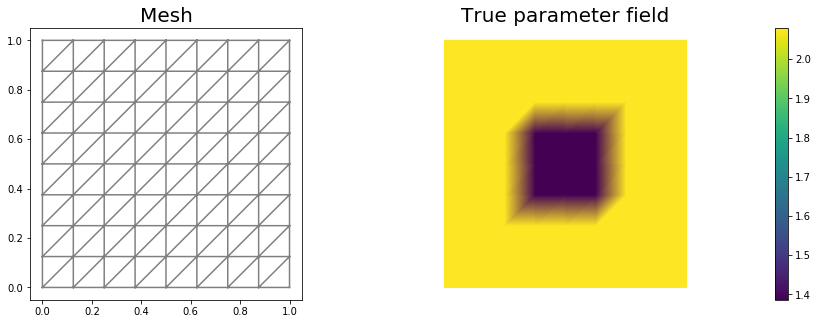

In [2]:
# create mesh and define function spaces
nx = 8
ny = 8
mesh = dl.UnitSquareMesh(nx, ny)
Vm = dl.FunctionSpace(mesh, 'Lagrange', 1)
Vu = dl.FunctionSpace(mesh, 'Lagrange', 2)

# The true and initial guess for inverted parameter
mtrue = dl.interpolate(dl.Expression('std::log( 8. - 4.*(pow(x[0] - 0.5,2) + pow(x[1] - 0.5,2) < pow(0.2,2) ) )', degree=5), Vm)

# define function for state and adjoint
u = dl.Function(Vu)
m = dl.Function(Vm)
p = dl.Function(Vu)

# define Trial and Test Functions
u_trial, m_trial, p_trial = dl.TrialFunction(Vu), dl.TrialFunction(Vm), dl.TrialFunction(Vu)
u_test,  m_test,  p_test  = dl.TestFunction(Vu),  dl.TestFunction(Vm),  dl.TestFunction(Vu)

# initialize input functions
j  = dl.Expression("(x[0]-.5)*x[1]*(x[1]-1)", degree=3)

# plot
plt.figure(figsize=(15,5))
nb.plot(mesh, subplot_loc=121, mytitle="Mesh", show_axis='on')
nb.plot(mtrue, subplot_loc=122, mytitle="True parameter field")
plt.show()

In [3]:
# Fix the value of the state at the center of the domain
def d_boundary(x,on_boundary):
    return dl.near(x[0], .5) and dl.near(x[1], .5)

u0 = dl.Constant(0.)
bc_state = dl.DirichletBC(Vu, u0, d_boundary, "pointwise")
bc_adj   = dl.DirichletBC(Vu, dl.Constant(0.), d_boundary, "pointwise")

### Set up synthetic observations (inverse crime):

To generate the synthetic observation we first solve the PDE for the state variable ``utrue`` corresponding to the true parameter ``mtrue``.
Specifically, we solve the variational problem

Find $u\in \mathcal{V}$ such that 

$$\underbrace{\int_\Omega e^{m_{\text true}} \nabla u \cdot \nabla v \, dx}_{\; := \; a_{\rm true}} - \underbrace{\int_{\partial\Omega} j\,v\,dx}_{\; := \;L_{\rm true}} = 0, \text{ for all } v\in \mathcal{V}$$.

Then we perturb the true state variable and write the observation ``d`` as

$$ d = u_{\rm true} + \eta, \quad {\rm where} \; \eta \sim \mathcal{N}(0, \sigma^2).$$

Here the standard variation $\sigma$ is proportional to ``noise_level``.

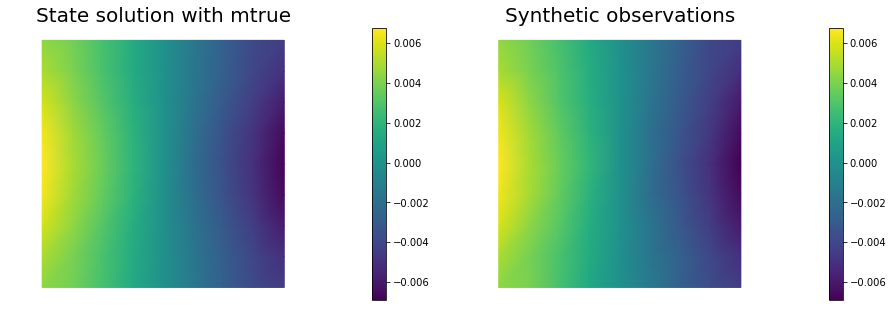

In [4]:
# noise level
noise_level = 0.01

# weak form for setting up the synthetic observations
a_true = dl.inner( dl.exp(mtrue) * dl.grad(u_trial), dl.grad(u_test)) * dl.dx
L_true = j * u_test * dl.ds

# solve the forward/state problem to generate synthetic observations
A_true, b_true = dl.assemble_system(a_true, L_true, bc_state)

utrue = dl.Function(Vu)
dl.solve(A_true, utrue.vector(), b_true)

d = dl.Function(Vu)
d.assign(utrue)

# perturb state solution and create synthetic measurements d
# d = u + ||u||/SNR * random.normal
MAX = d.vector().norm("linf")
noise = dl.Vector()
A_true.init_vector(noise,1)
noise.set_local( noise_level * MAX * np.random.normal(0, 1, len(d.vector().get_local())) )
bc_adj.apply(noise)

d.vector().axpy(1., noise)

# plot
nb.multi1_plot([utrue, d], ["State solution with mtrue", "Synthetic observations"])
plt.show()

### The cost functional evaluation:

$$
J(m):=\underbrace{\frac{1}{2}\int_\Omega (u-d)^2\, dx}_{\text misfit} + \underbrace{\frac{\gamma}{2}\int_\Omega|\nabla m|^2\,dx}_{\text reg}
$$

In [5]:
# Regularization parameter
gamma = 1e-9

# Define cost function
def cost(u, d, m, gamma):
    reg = 0.5*dl.assemble( dl.inner(dl.grad(m), dl.grad(m))*dl.dx ) 
    misfit = 0.5 * dl.assemble( (u-d)**2*dl.dx)
    return [gamma*reg + misfit, misfit, reg]

### Setting up the variational form for the state/adjoint equations and gradient evaluation

Below we define the variational forms that appears in the the state/adjoint equations and gradient evaluations.

Specifically,

- `a_state`, `L_state` stand for the bilinear and linear form of the state equation, repectively;
- `a_adj`, `L_adj` stand for the bilinear and linear form of the adjoint equation, repectively;
- `grad_misfit`, `grad_reg` stand for the contributions to the gradient coming from the data misfit and the regularization, respectively.

We also build the *mass* matrix $M$ that is used to discretize the $L^2(\Omega)$ inner product.

In [6]:
# weak form for setting up the state equation
a_state = dl.inner( dl.exp(m) * dl.grad(u_trial), dl.grad(u_test)) * dl.dx
L_state = j * u_test * dl.ds

# weak form for setting up the adjoint equations
a_adj = dl.inner( dl.exp(m) * dl.grad(p_trial), dl.grad(p_test) ) * dl.dx
L_adj = - dl.inner(u - d, p_test) * dl.dx

# weak form for gradient
grad_misfit = dl.inner(dl.exp(m)*m_test*dl.grad(u), dl.grad(p)) * dl.dx
grad_reg    = dl.Constant(gamma)*dl.inner(dl.grad(m), dl.grad(m_test))*dl.dx

# Mass matrix in parameter space
Mvarf    = dl.inner(m_trial, m_test) * dl.dx
M = dl.assemble(Mvarf)

### Finite difference check of the gradient

We use a **finite difference check** to verify that our gradient derivation is correct.
Specifically, we consider a function $ m_0\in \mathcal{M}$ and we verify that for an arbitrary direction $\tilde{m} \in \mathcal{M}$ we have
$$ r := \left| \frac{ \mathcal{J}(m_0 + \varepsilon \tilde{m}) - \mathcal{J}(m_0)}{\varepsilon} -  \left(\mathcal{G}(m_0), \tilde{m}\right)\right| = \mathcal{O}(\varepsilon).$$

In the figure below we show in a loglog scale the value of $r$ as a function of $\varepsilon$. We observe that $r$ decays linearly for a wide range of values of $\varepsilon$, however we notice an increase in the error for extremely small values of $\varepsilon$ due to numerical stability and finite precision arithmetic.


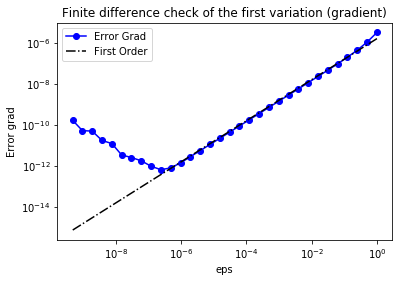

In [7]:
m0 = dl.interpolate(dl.Constant(np.log(4.) ), Vm )

n_eps = 32
eps = np.power(2., -np.arange(n_eps))
err_grad = np.zeros(n_eps)

m.assign(m0)

#Solve the fwd problem and evaluate the cost functional
A, state_b = dl.assemble_system (a_state, L_state, bc_state)
dl.solve(A, u.vector(), state_b)

c0, _, _ = cost(u, d, m, gamma)

# Solve the adjoint problem and evaluate the gradient
adj_A, adjoint_RHS = dl.assemble_system(a_adj, L_adj, bc_adj)
dl.solve(adj_A, p.vector(), adjoint_RHS)

# evaluate the  gradient
grad0 = dl.assemble(grad_misfit + grad_reg)

# Define an arbitrary direction m_hat to perform the check 
mtilde = dl.Function(Vm).vector()
mtilde.set_local(np.random.randn(Vm.dim()))
mtilde.apply("")
mtilde_grad0 = grad0.inner(mtilde)

for i in range(n_eps):
    m.assign(m0)
    m.vector().axpy(eps[i], mtilde)
    
    A, state_b = dl.assemble_system (a_state, L_state, bc_state)
    dl.solve(A, u.vector(), state_b)

    cplus, _, _ = cost(u, d, m, gamma)
   
    err_grad[i] = abs( (cplus - c0)/eps[i] - mtilde_grad0 )

plt.figure()    
plt.loglog(eps, err_grad, "-ob", label="Error Grad")
plt.loglog(eps, (.5*err_grad[0]/eps[0])*eps, "-.k", label="First Order")
plt.title("Finite difference check of the first variation (gradient)")
plt.xlabel("eps")
plt.ylabel("Error grad")
plt.legend(loc = "upper left")
plt.show()

### Initial guess

We solve the state equation and compute the cost functional for the initial guess of the parameter ``m0``

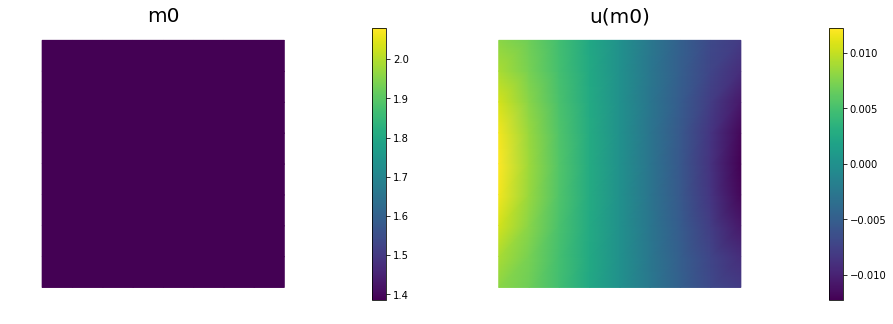

In [8]:
m.assign(m0)

# solve state equation
A, state_b = dl.assemble_system (a_state, L_state, bc_state)
dl.solve(A, u.vector(), state_b)

# evaluate cost
[cost_old, misfit_old, reg_old] = cost(u, d, m, gamma)

# plot
plt.figure(figsize=(15,5))
nb.plot(m,subplot_loc=121, mytitle="m0", vmin=mtrue.vector().min(), vmax=mtrue.vector().max())
nb.plot(u,subplot_loc=122, mytitle="u(m0)")
plt.show()

## The steepest descent with Armijo line search:

We solve the constrained optimization problem using the steepest descent method with Armijo line search.

The stopping criterion is based on a relative reduction of the norm of the gradient (i.e. $\frac{\|g_{n}\|}{\|g_{0}\|} \leq \tau$).

The gradient is computed by solving the state and adjoint equation for the current parameter $m$, and then substituing the current state $u$, parameter $m$ and adjoint $p$ variables in the weak form expression of the gradient:

$$ (g, \tilde{m}) = \gamma(\nabla m, \nabla \tilde{m}) +(\tilde{m}e^m\nabla u, \nabla p).$$

The Armijo line search uses backtracking to find $\alpha$ such that a sufficient reduction in the cost functional is achieved.
Specifically, we use backtracking to find $\alpha$ such that:

$$J( m - \alpha g ) \leq J(m) - \alpha c_{\rm armijo} (g,g). $$


Nit  cost          misfit        reg         ||grad||       alpha  N backtrack
  0   3.02623e-06   3.01160e-06   1.46345e+01   1.68847e-05   1.00000e+05     0


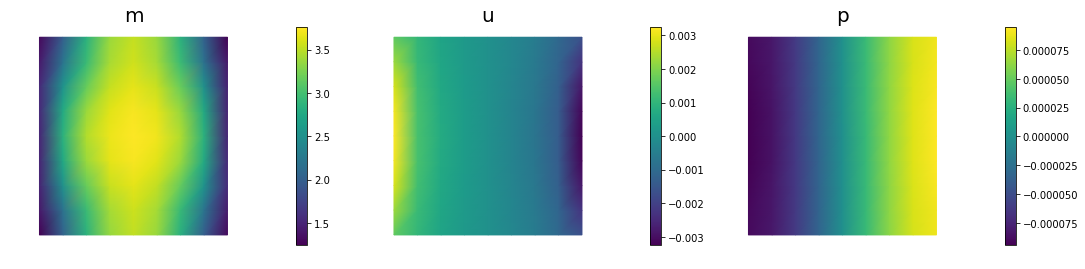

 10   2.39746e-08   2.24789e-08   1.49576e+00   3.20226e-07   1.00000e+05     0
 20   5.75131e-09   4.01537e-09   1.73594e+00   6.23213e-08   1.00000e+05     0
 30   4.27005e-09   2.71222e-09   1.55782e+00   7.85614e-08   5.00000e+04     1
 40   3.58402e-09   2.18443e-09   1.39959e+00   5.56672e-08   5.00000e+04     1
 50   3.21787e-09   1.92794e-09   1.28993e+00   3.92951e-08   1.00000e+05     0


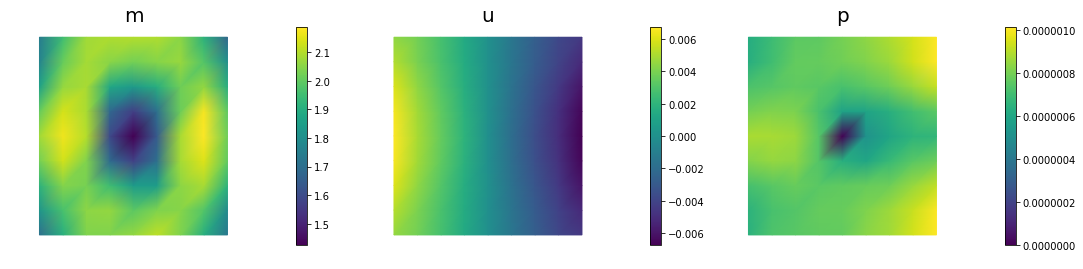

 60   2.94046e-09   1.71872e-09   1.22174e+00   2.73789e-08   1.00000e+05     0
 70   2.76604e-09   1.58846e-09   1.17758e+00   1.91391e-08   1.00000e+05     0
 80   2.65329e-09   1.50435e-09   1.14894e+00   1.36771e-08   1.00000e+05     0
 90   2.57856e-09   1.44809e-09   1.13047e+00   1.01305e-08   1.00000e+05     0
100   2.52800e-09   1.40931e-09   1.11869e+00   1.93698e-08   5.00000e+04     1


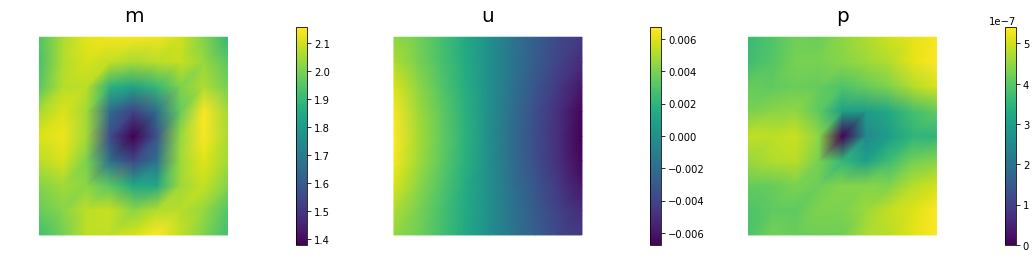

110   2.49328e-09   1.38194e-09   1.11134e+00   1.22603e-08   5.00000e+04     1
120   2.46991e-09   1.36293e-09   1.10698e+00   8.03805e-09   1.00000e+05     0
130   2.45215e-09   1.34773e-09   1.10442e+00   5.55756e-09   1.00000e+05     0
140   2.44009e-09   1.33698e-09   1.10311e+00   4.08324e-09   1.00000e+05     0
150   2.43173e-09   1.32914e-09   1.10259e+00   7.63177e-09   5.00000e+04     1


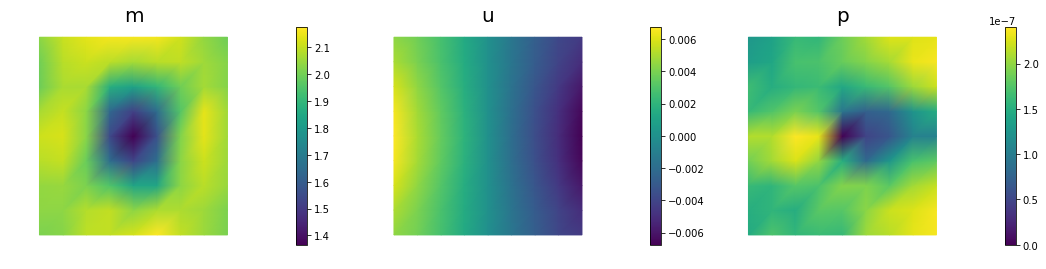

160   2.42638e-09   1.32362e-09   1.10275e+00   4.78849e-09   1.00000e+05     0
170   2.42178e-09   1.31883e-09   1.10295e+00   3.15826e-09   1.00000e+05     0
180   2.41872e-09   1.31539e-09   1.10333e+00   2.22150e-09   1.00000e+05     0
190   2.41660e-09   1.31281e-09   1.10379e+00   1.66679e-09   1.00000e+05     0
Steepest descent converged in  190   iterations


In [9]:
# define parameters for the optimization
tol = 1e-4
maxiter = 1000
print_any = 10
plot_any = 50
c_armijo = 1e-5

# initialize iter counters
iter = 0
converged = False

# initializations
g = dl.Vector()
M.init_vector(g,0)

m_prev = dl.Function(Vm)

print( "Nit  cost          misfit        reg         ||grad||       alpha  N backtrack" )

while iter <  maxiter and not converged:

    # solve the adoint problem
    adj_A, adjoint_RHS = dl.assemble_system(a_adj, L_adj, bc_adj)
    dl.solve(adj_A, p.vector(), adjoint_RHS)

    # evaluate the  gradient
    MG = dl.assemble(grad_misfit + grad_reg)
    dl.solve(M, g, MG)

    # calculate the norm of the gradient
    grad_norm2 = g.inner(MG)
    gradnorm = np.sqrt(grad_norm2)
    
    if iter == 0:
        gradnorm0 = gradnorm

    # linesearch
    it_backtrack = 0
    m_prev.assign(m)
    alpha = 1.e5
    backtrack_converged = False
    for it_backtrack in range(20):
        
        m.vector().axpy(-alpha, g )

        # solve the forward problem
        state_A, state_b = dl.assemble_system(a_state, L_state, bc_state)
        dl.solve(state_A, u.vector(), state_b)

        # evaluate cost
        [cost_new, misfit_new, reg_new] = cost(u, d, m, gamma)

        # check if Armijo conditions are satisfied
        if cost_new < cost_old - alpha * c_armijo * grad_norm2:
            cost_old = cost_new
            backtrack_converged = True
            break
        else:
            alpha *= 0.5
            m.assign(m_prev)  # reset m
            
    if backtrack_converged == False:
        print( "Backtracking failed. A sufficient descent direction was not found" )
        converged = False
        break

    sp = ""
    if (iter % print_any)== 0 :
        print( "%3d %1s %8.5e %1s %8.5e %1s %8.5e %1s %8.5e %1s %8.5e %1s %3d" % \
            (iter, sp, cost_new, sp, misfit_new, sp, reg_new, sp, \
            gradnorm, sp, alpha, sp, it_backtrack) )

    if (iter % plot_any)== 0 :
        nb.multi1_plot([m,u,p], ["m","u","p"], same_colorbar=False)
        plt.show()
    
    # check for convergence
    if gradnorm < tol*gradnorm0 and iter > 0:
        converged = True
        print ("Steepest descent converged in ",iter,"  iterations")
        
    iter += 1
    
if not converged:
    print ( "Steepest descent did not converge in ", maxiter, " iterations")

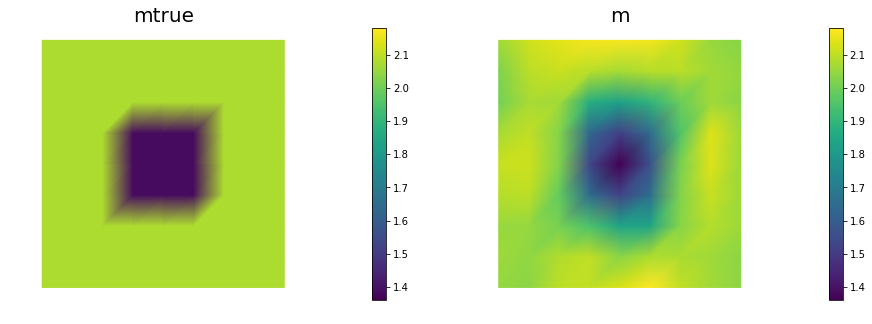

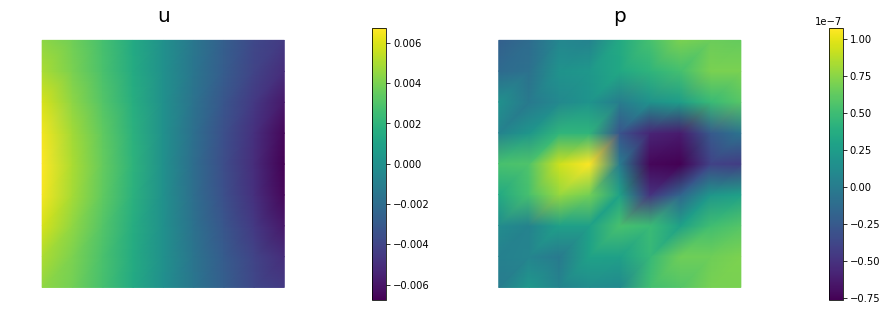

In [10]:
nb.multi1_plot([mtrue, m], ["mtrue", "m"])
nb.multi1_plot([u,p], ["u","p"], same_colorbar=False)
plt.show()

---

Copyright &copy; 2019, Washington University in St. Louis.

All Rights reserved.
See file COPYRIGHT for details.

This file is part of **cmis_labs**, the teaching material for the S2019 BME 493/593 course on *Computational Methods in Imaging Science* at Washington University in St. Louis. Please see [https://uvilla.github.io/cmis_labs](https://uvilla.github.io/cmis_labs) for more information and source code availability.

We would like to acknowledge the Extreme Science and Engineering Discovery Environment (XSEDE), which is supported by National Science Foundation grant number ACI-1548562, for providing cloud computing resources (Jetstream) for this course through allocation TG-SEE190001.